## Notebook 3 : 03_eda_and_feature_engineering.ipynb

#### Author: Satveer Kaur
#### Date: 2025-10-28

#### Notebook Purpose:

This notebook initiates the **Exploratory Data Analysis (EDA)** and **Feature Engineering** phase, utilizing the efficient, stratified sample created in Notebook 02. The core focus is on validating the project's primary hypothesis: identifying and structuring the most predictive **risk drivers** for segmentation.

**Primary Objective:** To develop auditable and analytically sound features that exhibit a clear, monotonic relationship with the Observed Default Rate (ODR).

**Key Deliverables:**

1. **Feature Validation:** Perform targeted EDA on the primary risk features (FICO Score, DTI, Income) against the `is_default` target.
2. **Binning Logic:** Develop and implement robust binning (segmentation) logic for continuous variables.
3. **Risk Metrics:** Calculate and visualize Observed Default Rate (ODR) and Weight of Evidence (WOE) for each new feature segment to guide modeling.

**Input:** `sample_data_for_development.csv` (Output from Notebook 02).

**Output:** `binned_sample_for_modeling.csv` (Input for Notebook 04). 

#### 1. Setup and Data Ingestion
**Purpose**: To initialize the Python environment and load the stratified development sample (`sample_data_for_development.csv`), which will be used exclusively for rapid Exploratory Data Analysis (EDA) and iterative feature engineering.

In [13]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for professional visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50) 
pd.set_option('display.float_format', '{:.4f}'.format) # Using 4 decimal places for risk metrics

# Load sample datasets
df_sample= pd.read_csv('../data/processed/sample_data_for_development.csv', low_memory=False, parse_dates=['issue_date'])


#### 2. Exploratory Data Analysis (EDA) on Key Risk Drivers

##### 2.1 FICO Score vs. Default Rate

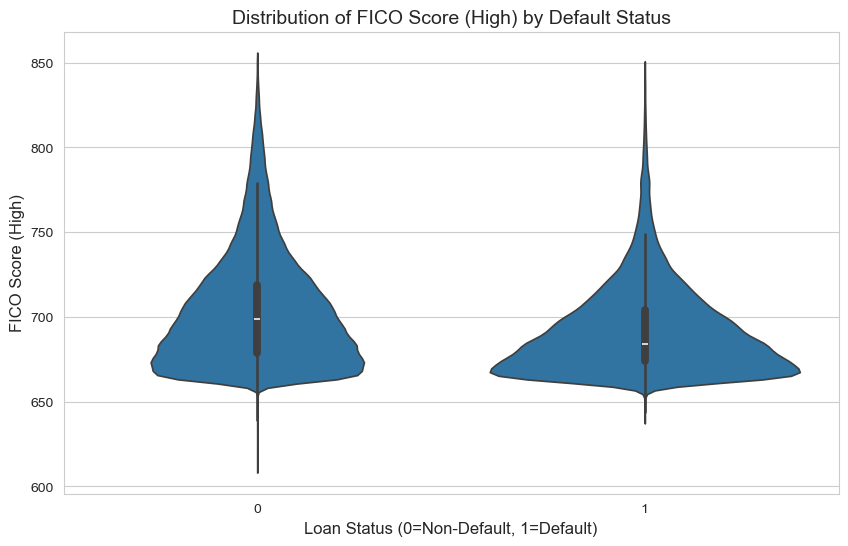

                 count     mean     std      min      25%      50%      75%  \
is_default                                                                    
0          199130.0000 704.0957 33.6297 614.0000 679.0000 699.0000 719.0000   
1           26936.0000 691.9190 26.0960 644.0000 674.0000 684.0000 704.0000   

                max  
is_default           
0          850.0000  
1          844.0000  


In [14]:
# Use a violin plot to show the density distribution
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='is_default', 
    y='fico_high', # FICO high is often used as a single score
    data=df_sample
)
plt.title('Distribution of FICO Score (High) by Default Status', fontsize=14)
plt.xlabel('Loan Status (0=Non-Default, 1=Default)',fontsize=12)
plt.ylabel('FICO Score (High)', fontsize=12)
plt.show()

# Quick Descriptive Stats
print(df_sample.groupby('is_default')['fico_high'].describe())

##### 2.2 Debt-to-income Ratio (DTI) vs. Default Rate

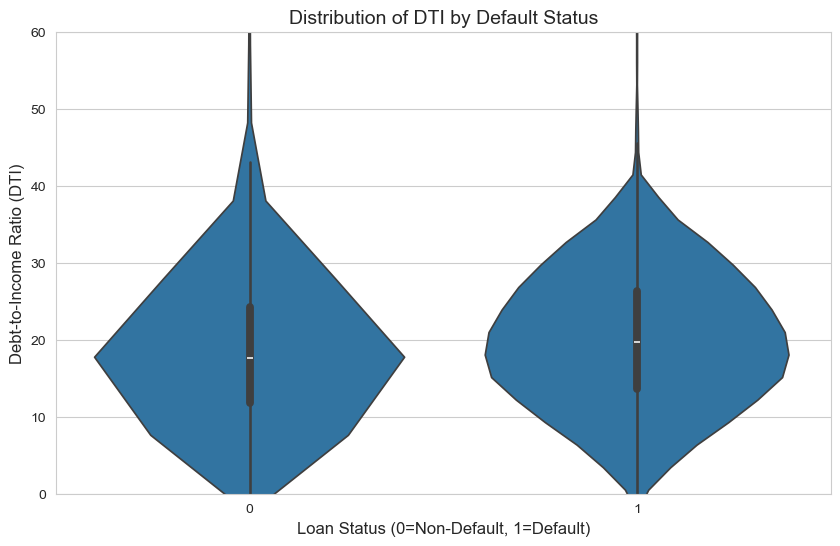

                 count    mean     std    min     25%     50%     75%      max
is_default                                                                    
0          198967.0000 18.7026 14.7455 0.0000 11.7300 17.6100 24.2500 999.0000
1           26930.0000 20.1206  9.5168 0.0000 13.5800 19.7050 26.3600 284.5400


In [15]:
# Use a violin plot to show the density distribution
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='is_default', 
    y='debt_to_income_ratio', 
    data=df_sample
)
plt.title('Distribution of DTI by Default Status', fontsize=14)
plt.xlabel('Loan Status (0=Non-Default, 1=Default)',fontsize=12)
plt.ylabel('Debt-to-Income Ratio (DTI)',fontsize=12)

# fix: Limit y-axis for readability
plt.ylim(0,60)
plt.show()

# Quick Descriptive Stats
print(df_sample.groupby('is_default')['debt_to_income_ratio'].describe())

##### 2.3 Annual Income vs. Default Rate

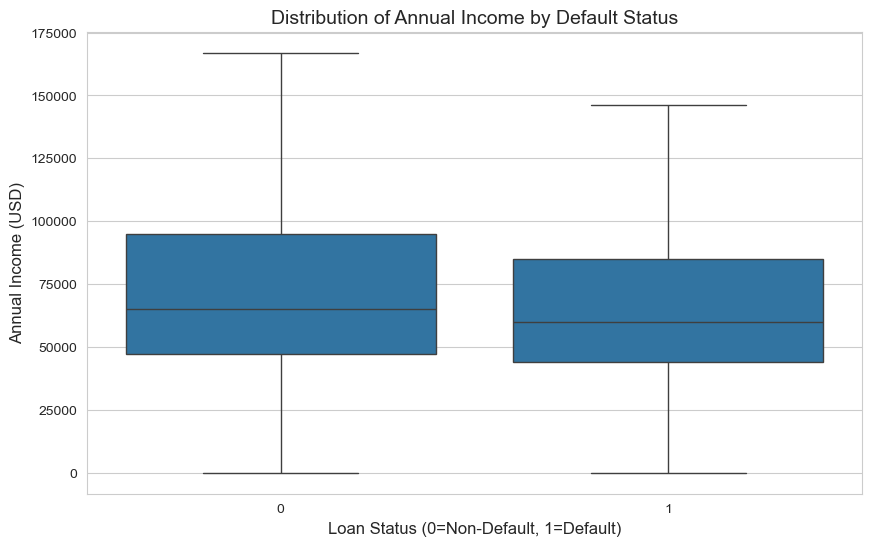

                 count       mean        std    min        25%        50%  \
is_default                                                                  
0          199129.0000 79132.6524 84465.5745 0.0000 47000.0000 65000.0000   
1           26936.0000 70098.5098 43775.8085 0.0000 44000.0000 60000.0000   

                  75%          max  
is_default                          
0          95000.0000 9300086.0000  
1          85000.0000 1020000.0000  


In [16]:
# Use a box plot for skewed data to show median and quartiles
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='is_default', 
    y='annual_income', 
    data=df_sample,
    showfliers=False # Hide extreme outliers for better visual focus
)
plt.title('Distribution of Annual Income by Default Status', fontsize=14)
plt.xlabel('Loan Status (0=Non-Default, 1=Default)', fontsize=12)
plt.ylabel('Annual Income (USD)', fontsize=12)
plt.show()

# Quick Descriptive Stats
print(df_sample.groupby('is_default')['annual_income'].describe())

#### 3. Feature Engineering: Developing Bins
**Purpose:** To implement justified, **robust binning (segmentation)** for the FICO, DTI and Income feature. This transforms the continuous variable into a discrete, auditable feature for modeling and reporting, enabling the calculation of risk metrics like Observed Default Rate (ODR).

##### 3.1 FICO Score Binning

In [17]:
# Create a single FICO score by taking the mean of the high and low range
df_sample.loc[:, 'fico_score']= df_sample[['fico_high', 'fico_low']].mean(axis=1)
max_score= df_sample['fico_score'].max()
max_score

# FICO Score cut-offs based on industry standards
fico_bins = [
    0,
    670, # boundary for subprime/poor
    740, # boundary for good/very good
    800, # boundary for very good/excellent
    max_score+1  # upper limit
]

fico_labels = [
    'FICO_Subprime/Poor (<670)', 
    'FICO_Good (670-739)', 
    'FICO_Very Good (740-799)', 
    'FICO_Excellent (800+)'
]

# Create new binned feature
fico_binned = pd.cut(
    df_sample['fico_score'],
    bins=fico_bins,
    labels=fico_labels,
    right=False, # The bins are inclusive on the left 
    include_lowest=True
)
df_sample.loc[:,'fico_group'] = fico_binned

# Observed Default Rate by FICO Group
fico_risk_analysis = df_sample.groupby('fico_group', observed=True)['is_default'].mean()

print('--- Observed Default Rate by FICO Group ---')
# The rate should be monotonically decreasing (Lower FICO -> Higher ODR)
print(fico_risk_analysis.sort_values(ascending=False).map('{:.2%}'.format))

--- Observed Default Rate by FICO Group ---
fico_group
FICO_Subprime/Poor (<670)    17.32%
FICO_Good (670-739)          11.91%
FICO_Very Good (740-799)      5.16%
FICO_Excellent (800+)         3.21%
Name: is_default, dtype: object


##### 3.2 Debt To Income Ratio Binning

In [18]:
# Create 5 bins (quintiles) of equal population size for DTI
dti_binned = pd.qcut(
    df_sample['debt_to_income_ratio'],
    q=5, # Creates 5 bins of equal population size
    labels=[
        'DTI_Q1 (Lowest Risk)', # 0 (Lowest DTI)
        'DTI_Q2',               # 1
        'DTI_Q3',               # 2
        'DTI_Q4',               # 3
        'DTI_Q5 (Highest Risk)' # 4 (Highest DTI)
    ],
    # 'drop' handles cases where multiple loans share the same DTI value at the cut-off
    duplicates='drop' 
)
# Assign the new Categorical Series to the DataFrame
df_sample.loc[:, 'dti_quintile'] = dti_binned

# Observed Default Rate by DTI Quintile 
dti_risk_analysis = df_sample.groupby('dti_quintile', observed=True)['is_default'].mean()

print('--- Observed Default Rate by DTI Quintile ---')
# The rate should be monotonically decreasing (Q5 > Q1)
print(dti_risk_analysis.sort_values(ascending=False).map('{:.2%}'.format))


--- Observed Default Rate by DTI Quintile ---
dti_quintile
DTI_Q5 (Highest Risk)    15.20%
DTI_Q4                   13.15%
DTI_Q3                   11.80%
DTI_Q2                   10.37%
DTI_Q1 (Lowest Risk)      9.11%
Name: is_default, dtype: object


##### 3.3 Annual Income Binning

In [19]:
# Cap extremely high income outliers
income_max_cap = 250_000

income_bins = [
    0,
    50_000,
    100_000,
    150_000,
    income_max_cap + 1
]
income_labels = [
    '< $50k','$50k - $100k','$100k - $150k','> $150k'
]
# Create the new binned feature
income_binned = pd.cut(
    df_sample['annual_income'], 
    bins=income_bins, 
    labels=income_labels, 
    right=False, # Interval is [low, high)
    include_lowest=True
)
# Assign the new Categorical Series to the DataFrame
df_sample.loc[:, 'income_group'] = income_binned

# Observed Default Rate by Income Group 
income_risk_analysis = df_sample.groupby('income_group', observed=True)['is_default'].mean()

print('--- Observed Default Rate by Income Group ---')
# The rate should be monotonically decreasing (Higher Income -> Lower ODR)
print(income_risk_analysis.sort_values(ascending=False).map('{:.2%}'.format))


--- Observed Default Rate by Income Group ---
income_group
< $50k           13.89%
$50k - $100k     12.05%
$100k - $150k     9.59%
> $150k           8.15%
Name: is_default, dtype: object


In [20]:
# Default groups 
default_statuses = [
    'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'
]

# Create is_default columns: 1 if status in default list, 0 otherwise
df_sample['is_default'] =  df_sample['loan_status'].apply(
    lambda x : 1 if x in default_statuses else 0
)

default_rate = df_sample['is_default'].mean() * 100
print('Target Variable "is_default" created')
print(f'Observed Default Rate (ODR) in the full portfolio: {default_rate:.2f}%')

Target Variable "is_default" created
Observed Default Rate (ODR) in the full portfolio: 11.92%


#### 4. Monotonicity Validation (ODR Plots)
**Purpose:** To generate professional visualizations that graphically confirm the monotonic relationship between the newly engineered features (**FICO, DTI, Income**) and the target variable (`is_default`). Monotonicity (risk consistently increasing or decreasing across segments) is a strict requirement for auditable risk models.

##### 4.1 Define ODR Plotting Function
**Purpose:** This function calculates the ODR for each group and plots it, along with the percentage of loans in that group (for volume validation).

In [21]:
def plot_segment_odr(df, group_col, title):
    """
    Calculates ODR and volume percentage for each segment and plots the ODR.
    """
    # Calculate ODR (mean of is_default) and Volume (count)
    risk_analysis = df.groupby(group_col, observed=True)['is_default'].agg(['count', 'mean'])
    risk_analysis.rename(columns={'mean': 'ODR', 'count': 'Volume'}, inplace=True)
    
    # Calculate Volume Proportion
    risk_analysis['volume_pct'] = (risk_analysis['Volume'] / risk_analysis['Volume'].sum()) 
    
    # Create the DataFrame used for plotting (reset index)
    plot_df = risk_analysis.reset_index()
    # plot_df[group_col] = plot_df[group_col].astype('category')

    # Create the figure and axes
    fig, ax_odr = plt.subplots(figsize=(10, 6))
    # ax_volume is the right axis, linked to the same X-axis
    ax_volume = ax_odr.twinx()

    # Plot ODR (Bar Chart on Left Y-Axis)
    sns.barplot(
        x=group_col, 
        y='ODR', 
        data=plot_df,
        hue=group_col,
        palette='Reds_d',
        ax=ax_odr
    )
    ax_odr.set_title(title, fontsize=14)
    ax_odr.set_ylabel('Observed Default Rate (ODR)', color='darkred', fontsize=12)
    ax_odr.tick_params(axis='y', labelcolor='darkred')
    ax_odr.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:.0%}' if x else '0'))
    

    # Plot Volume Percentage (Line Plot on Right Y-Axis) 
    sns.lineplot(
        x=group_col, 
        y='volume_pct', 
        data=plot_df, 
        color='darkblue',
        marker='o',
        linewidth=2,
        ax=ax_volume
    )
    ax_volume.set_ylabel('Volume Percentage', color='darkblue', fontsize=12)
    ax_volume.tick_params(axis='y', labelcolor='darkblue')
    ax_volume.grid(False) # Turn off the grid for the right axis
    ax_volume.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{x:.0%}' if x else '0'))

    # Add ODR values on top of bars
    for index, row in plot_df.iterrows():
        ax_odr.text(
            index, 
            row['ODR'] + 0.001, 
            f'{row["ODR"]:.2%}', 
            color='black', 
            ha="center", 
            size=10
        )
    
    plt.tight_layout()
    plt.show()

##### 4.2 ODR Plots

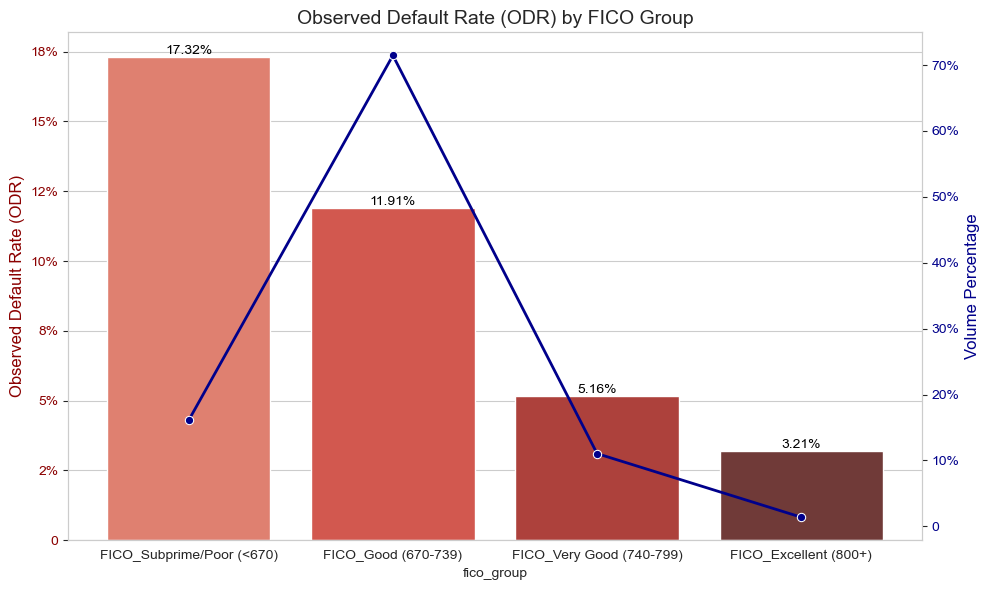

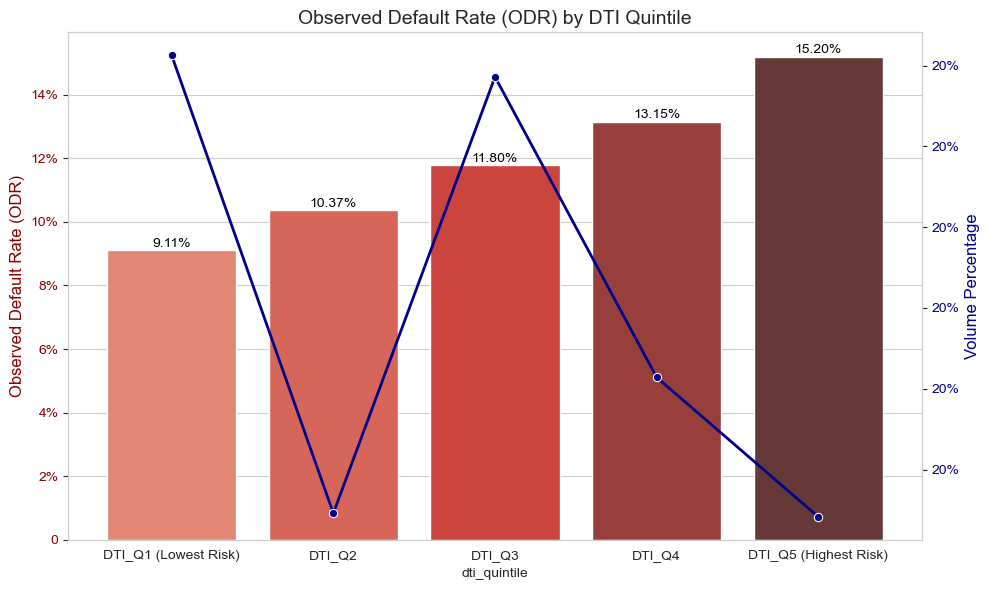

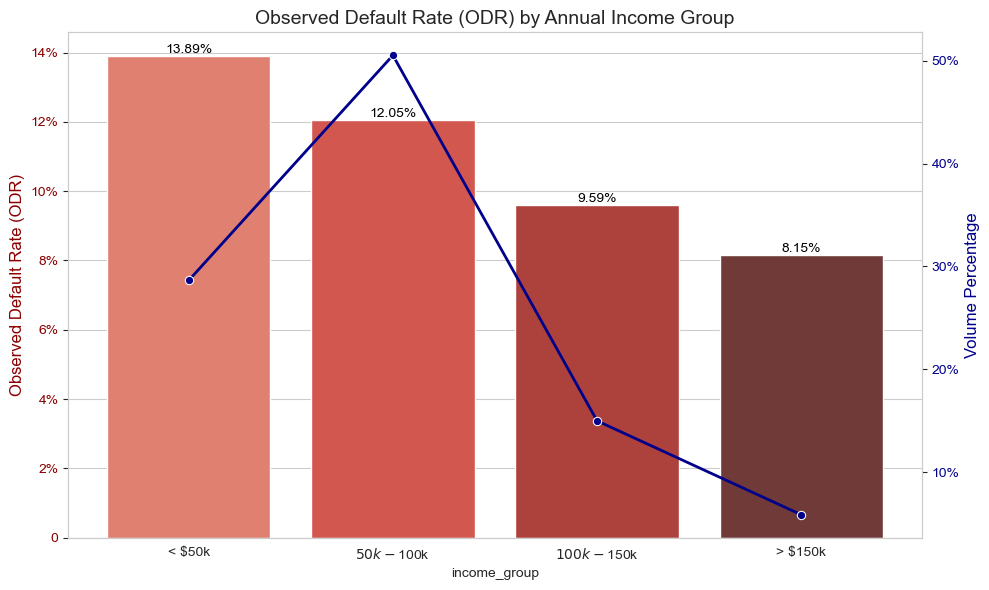

In [22]:
# --- FICO Score Monotonicity ---
plot_segment_odr(
    df_sample, 
    'fico_group', 
    'Observed Default Rate (ODR) by FICO Group'
)

# --- DTI Ratio Monotonicity ---
plot_segment_odr(
    df_sample, 
    'dti_quintile', 
    'Observed Default Rate (ODR) by DTI Quintile'
)

# --- Annual Income Monotonicity ---
plot_segment_odr(
    df_sample, 
    'income_group', 
    'Observed Default Rate (ODR) by Annual Income Group'
)

#### 5. Checkpoint and export Final Sample Data 
**Purpose:** To save the final, engineered sample data. This dataset, containing the new `fico_group`, `dti_quintile`, and `income_group` features, is the definitive input for the next phase of modeling.

In [23]:
output_path = '../data/processed/binned_sample_for_reporting.csv'
df_sample.to_csv(output_path, index=False)
print('Notebook 3 Complete. Final Engineered Sample Saved.')

Notebook 3 Complete. Final Engineered Sample Saved.


#### 6. Summary and Next Steps

##### Summary

This notebook successfully completed the feature engineering phase required to structure the data for meaningful analysis and reporting.

Key Analytical Insights Established:
1. **Risk Structuring:** The project's raw features (FICO score, DTI, Income) were transformed into structured, categorical risk segments: `fico_group`, `dti_quintile`, and `income_group`.
2. **Monotonicity Confirmed:** The dual-axis ODR plots visually confirmed that all three key risk drivers exhibit the required **monotonic relationship** — as the category improves (e.g., FICO score increases), the Observed Default Rate (ODR) consistently decreases. This validates the effectiveness of the segmentation.
3. **Volume Distribution:** The plots also highlight where the **largest volumes of loans** are clustered, allowing stakeholders to easily identify both high-risk segments and high-volume segments.
4. **Data Readiness:** The final, processed dataset is now ready for deep-dive analysis, reporting, and dashboard creation.

##### Next Steps
The project now transitions from feature preparation to Final Analysis and Reporting, focusing on extracting and presenting the primary business insights.

**Notebook 4: Final Analysis and Reporting** will involve:
1. **Load Data:** Load the `binned_sample_for_reporting.csv` file.
2. **Reporting Function (create_risk_table):** Define a function to generate the final, clean summary tables (ODR, Volume, and Volume Pct) for each of the three segments. These tables are the quantitative core of the report.
3. **Generate Final Evidence:** Execute the reporting function to generate and display the three definitive risk profile tables (FICO, DTI, and Income).
4. **Final Visualization:** Create any necessary high-level comparative charts or polished versions of the ODR plots for the final report.
5. **Narrative & Conclusion:** Write the final analysis, translating the numbers from the tables and charts into clear, actionable business insights for the stakeholders.

The focus shifts entirely from **coding (the how)** to **insight generation (the why).**